Obtain the polynomial fit to  the GAIA-EDR3 -> DECam transformations

In [2]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

import healpy as hp

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [4]:
gaia_dir = '/project/projectdirs/cosmo/data/gaia/edr3/healpix'
gaia_nside = 32
gaia_npix = hp.nside2npix(gaia_nside)

In [ ]:
sweep_list = ['sweep-140p015-150p020.fits', 'sweep-150p015-160p020.fits',
              'sweep-160p015-170p020.fits', 'sweep-170p015-180p020.fits', 
              'sweep-180p015-190p020.fits', 'sweep-190p015-200p020.fits',
              'sweep-140p010-150p015.fits', 'sweep-150p010-160p015.fits',
              'sweep-160p010-170p015.fits', 'sweep-170p010-180p015.fits', 
              'sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits',
              'sweep-140p005-150p010.fits', 'sweep-150p005-160p010.fits',
              'sweep-160p005-170p010.fits', 'sweep-170p005-180p010.fits', 
              'sweep-180p005-190p010.fits', 'sweep-190p005-200p010.fits']

cat_stack = []
for sweep_fn in sweep_list:
    
    cat = Table(fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/'+sweep_fn,
        columns=['RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'TYPE', 'MASKBITS', 'FRACFLUX_R']))
    mask =  22.5 - 2.5*np.log10(cat['FLUX_R']) < 22.0
    # mask &= cat['TYPE']!='DUP'
    mask &= cat['TYPE']=='PSF'
    mask &= cat['FRACFLUX_R']<0.1
    cat = cat[mask]

    healpix_list = np.unique(hp.ang2pix(gaia_nside, cat['RA'], cat['DEC'], nest=True, lonlat=True))

    gaia = []
    for hp_index in healpix_list:
        gaia_fn = str(hp_index).zfill(5)
        gaia_chunk = Table(fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), columns=['SOURCE_ID', 'RA', 'DEC', 'PHOT_G_MEAN_MAG', 'PHOT_BP_MEAN_MAG', 'PHOT_RP_MEAN_MAG', 'PHOT_G_MEAN_FLUX_OVER_ERROR']))
        mask = (gaia_chunk['PHOT_G_MEAN_MAG']>16) & (gaia_chunk['PHOT_G_MEAN_MAG']<18)
        gaia_chunk = gaia_chunk[mask]
        gaia.append(gaia_chunk)
    gaia = vstack(gaia)
    idx1, idx2, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], gaia['RA'], gaia['DEC'], search_radius=0.5, plot_q=False)

    cat = cat[idx1]
    gaia = gaia[idx2]
    gaia.rename_columns(['RA', 'DEC'], ['RA', 'GAIA_DEC'])

    cat = hstack([cat, gaia])
    cat_stack.append(cat)
    
cat_stack = vstack(cat_stack)
cat = cat_stack
print(len(cat))

In [5]:
cat.write('/global/cfs/cdirs/desi/users/rongpu/misc/decals_dr9_gaia_edr3.fits')

In [5]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/misc/decals_dr9_gaia_edr3.fits'))

mask = (cat['PHOT_BP_MEAN_MAG']!=0) & (cat['PHOT_RP_MEAN_MAG']!=0)
print(np.sum(mask)/len(mask))
cat = cat[mask]

0.9996802655676579


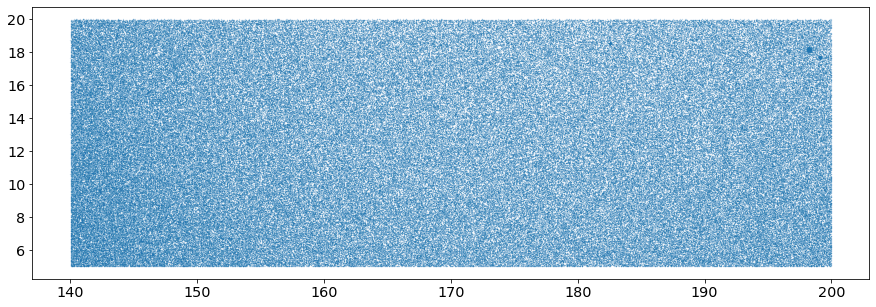

0.873302337394789
0.873302337394789
371343


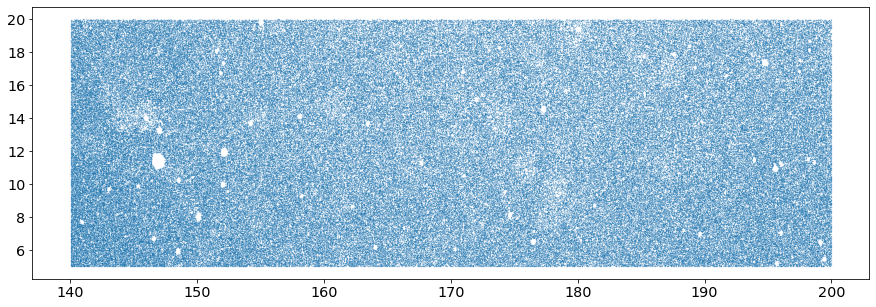

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

mask = (cat['MASKBITS']==0)
print(np.sum(mask)/len(mask))
mask &= np.isfinite(cat['PHOT_BP_MEAN_MAG']) & np.isfinite(cat['PHOT_RP_MEAN_MAG'])
print(np.sum(mask)/len(mask))
print(np.sum(mask))
cat = cat[mask]

plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    
for band in ['g', 'r', 'z']:
    print(band, cat[band+'mag'].min(), cat[band+'mag'].max())

g 15.692055 22.112179
r 15.168711 19.827345
z 14.842638 18.962343


__Supplement with bluest and reddest stars__

In [8]:
extreme = Table.read('/global/cfs/cdirs/desi/users/rongpu/misc/dr9_south_gaia_reddest_and_bluest.fits')

mask = (extreme['MASKBITS']==0)
print(np.sum(mask)/len(mask))
mask &= extreme['TYPE']=='PSF'
print(np.sum(mask)/len(mask))
mask &= extreme['FRACFLUX_R']<0.1
print(np.sum(mask)/len(mask))
mask = (extreme['FLUX_G']>0) & (extreme['FLUX_R']>0) & (extreme['FLUX_Z']>0)
print(np.sum(mask)/len(mask))

extreme = extreme[mask]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    extreme['gmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_G'])
    extreme['rmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_R'])
    extreme['zmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_Z'])
    
for band in ['g', 'r', 'z']:
    print(band, extreme[band+'mag'].min(), extreme[band+'mag'].max())

0.6190246257846451
0.6185417672621922
0.6102526959600837
0.9980685659101883
g 15.800625 23.413515
r 16.115398 21.90536
z 10.642838 24.503805


In [ ]:
plt.hist(cat['zmag'], 100);

__New polynomial fits__

In [35]:
import statsmodels.api as sm

def rlm_fit1d(x, y, t=1.5, order=1):
    '''
    1D robust polynomial fit.
    
    Given x array and y array, calculate the 1D robust 
    polynomial fit of arbitrary order. Huber weight
    function is used. 
    
    See also poly_val1d.py
    
    INPUT:
    1D arrays of x and y values; tunning parameter t; 
    order of the polynomial fit.
    
    OUTPUT:
    Array of parameters of the polynomial [a0, a1, a2 ...] 
    so that y = a0 + a1*x + a2*x**2 + ...
    '''
    
    ncols = order+1
    a = np.zeros((x.size,ncols))
    for i in range(order+1):
        a[:,i] = x**i
    res = sm.RLM(y, a, M=sm.robust.norms.HuberT(t=t)).fit()
    m = res.params
    return(m)

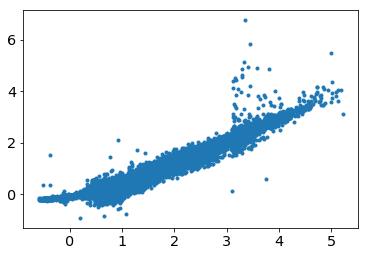

In [37]:
plt.plot(x, y, '.')

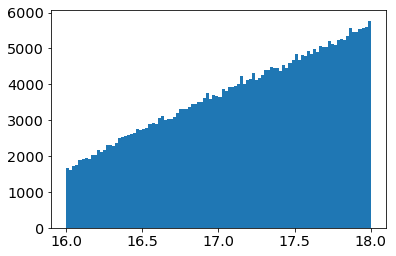

In [40]:
plt.hist(cat['PHOT_G_MEAN_MAG'], 100);

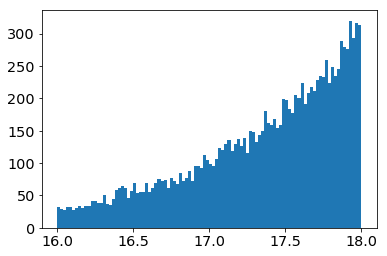

In [39]:
plt.hist(extreme['PHOT_G_MEAN_MAG'], 100);

In [ ]:
coeffs_new = {}

mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG']>3.1)

for band in ['g', 'r', 'z']:
    x = np.concatenate([(cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG'])[mask1]])
    y = np.concatenate([(cat[band+'mag']-cat['PHOT_G_MEAN_MAG'])[mask], (extreme[band+'mag']-extreme['PHOT_G_MEAN_MAG'])[mask1]])
    if band=='g' or band=='r':
        poly_order = 12
    else:
        poly_order = 7
    coeffs_new[band] = rlm_fit1d(x, y, t=0.1, order=poly_order)
    # coeffs_new[band] = np.polyfit(x, y, deg=2)
    print(band)
    print(coeffs_new[band])


KeyboardInterrupt



In [ ]:
g
[ -1.12568117e-01   3.50637700e-01   9.08202579e-01  -1.00783093e+00
  -1.42121314e+00   4.56857222e+00  -4.57194154e+00   2.38168873e+00
  -7.16227072e-01   1.24702144e-01  -1.14938710e-02   3.94958519e-04
   5.16473076e-06]
r
[  1.43127887e-01  -2.99979777e-01  -5.53379742e-02   1.54427312e-01
   3.06863469e-01  -9.49914390e-01   9.76973936e-01  -4.92670453e-01
   1.27253957e-01  -1.33178183e-02  -8.15381266e-04   3.09411601e-04
  -1.98890619e-05]
z
[ 0.51738143 -1.04501767  0.15297978  0.18560052 -0.23665801  0.10183312
 -0.01896732  0.00129884]

In [9]:
np.set_printoptions(precision=5)
float_formatter = "{:.10f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [11]:
coeffs_new

{'g': array([-0.1125681175, 0.3506376997, 0.9082025788, -1.0078309266,
        -1.4212131445, 4.5685722177, -4.5719415419, 2.3816887292,
        -0.7162270722, 0.1247021438, -0.0114938710, 0.0003949585,
        0.0000051647]),
 'r': array([0.1431278873, -0.2999797766, -0.0553379742, 0.1544273115,
        0.3068634689, -0.9499143903, 0.9769739362, -0.4926704528,
        0.1272539574, -0.0133178183, -0.0008153813, 0.0003094116,
        -0.0000198891]),
 'z': array([0.5173814296, -1.0450176704, 0.1529797809, 0.1856005222,
        -0.2366580132, 0.1018331214, -0.0189673240, 0.0012988354])}

In [10]:
coeffs_new = dict(
    g = [-0.1125681175, 0.3506376997, 0.9082025788, -1.0078309266,
        -1.4212131445, 4.5685722177, -4.5719415419, 2.3816887292,
        -0.7162270722, 0.1247021438, -0.0114938710, 0.0003949585,
        0.0000051647],
    r = [0.1431278873, -0.2999797766, -0.0553379742, 0.1544273115,
        0.3068634689, -0.9499143903, 0.9769739362, -0.4926704528,
        0.1272539574, -0.0133178183, -0.0008153813, 0.0003094116,
        -0.0000198891],
    z = [0.5173814296, -1.0450176704, 0.1529797809, 0.1856005222,
        -0.2366580132, 0.1018331214, -0.0189673240, 0.0012988354])

In [11]:
gaia_plot = Table()
gaia_plot['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['g', 'r', 'z']
for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot))
    for order, c in enumerate(coeffs_new[b]):
        mag += c * gaia_plot['BP_RP']**order
    gaia_plot['ls_'+b] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(cat['PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new[b]):
        mag += c * (cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])**order
    cat[b+'mag_predict'] = mag

In [20]:
bprp_min, bprp_max = -0.5, 4.5

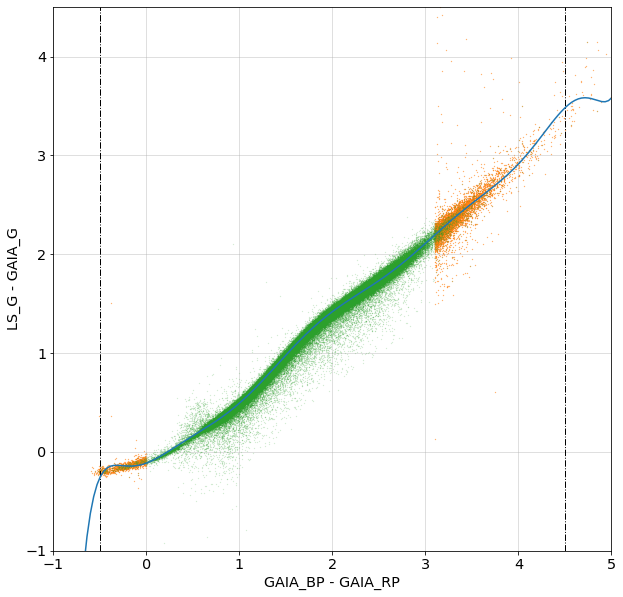

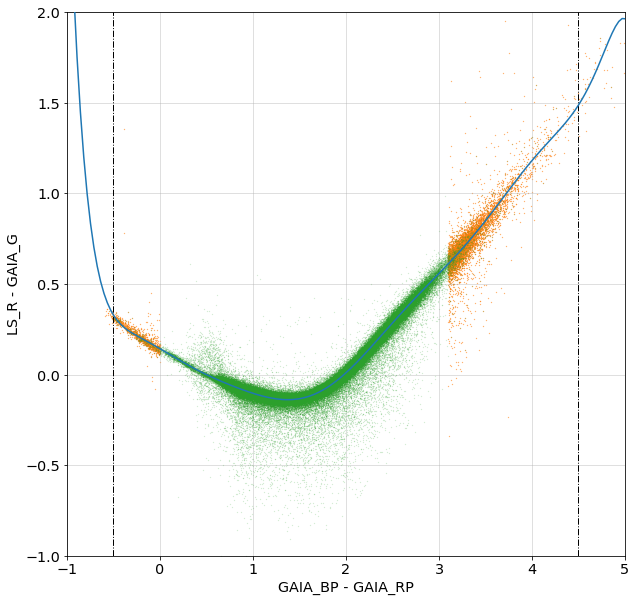

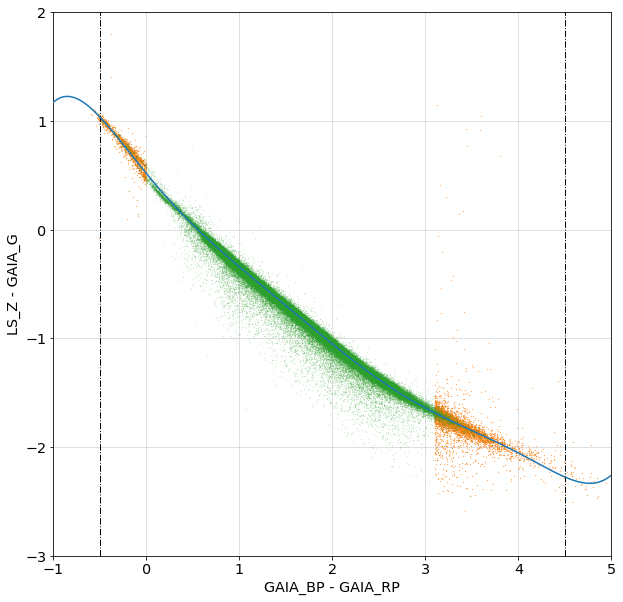

In [21]:
mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG']>3.1)

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['gmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG'])[mask1], (extreme['gmag']-extreme['PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_g']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_G - GAIA_G')
plt.axis([-1., 5., -1, 4.5])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('plots/decals_g.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['rmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG'])[mask1], (extreme['rmag']-extreme['PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_r']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_R - GAIA_G')
plt.axis([-1., 5., -1, 2])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('plots/decals_r.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot((cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['PHOT_BP_MEAN_MAG']-extreme['PHOT_RP_MEAN_MAG'])[mask1], (extreme['zmag']-extreme['PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_z']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_Z - GAIA_G')
plt.axis([-1., 5., -3, 2.])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('plots/decals_z.png')
plt.show()

In [14]:
from scipy import stats

nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))

def binned_median(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

def binned_std(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='std', bins=bins)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_std

def binned_nmad(x, y, nbins=50):
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_nmad, bin_edges, binnumber = stats.binned_statistic(x, y, statistic=nmad, bins=bins)
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_nmad

RMS 0.04537011
NMAD 0.01931411361694336


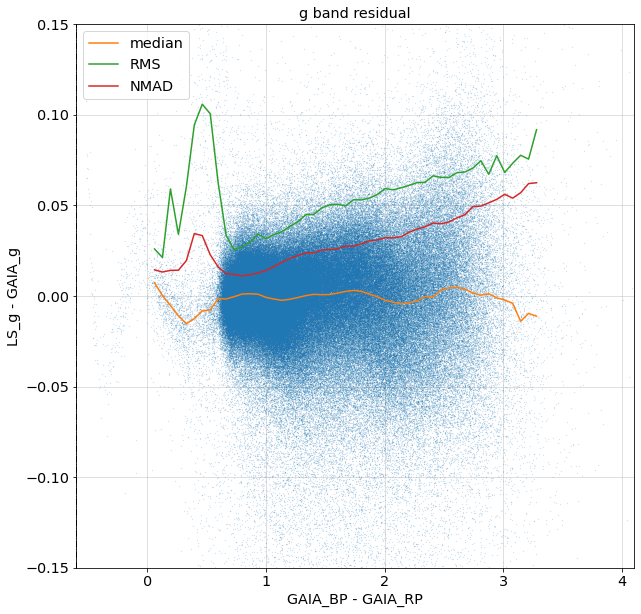

RMS 0.03883002
NMAD 0.012057888793945312


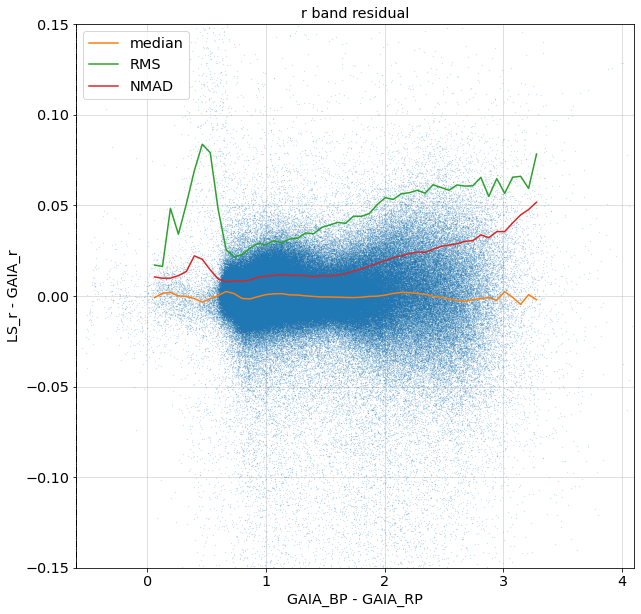

RMS 0.041268338
NMAD 0.01818863525390625


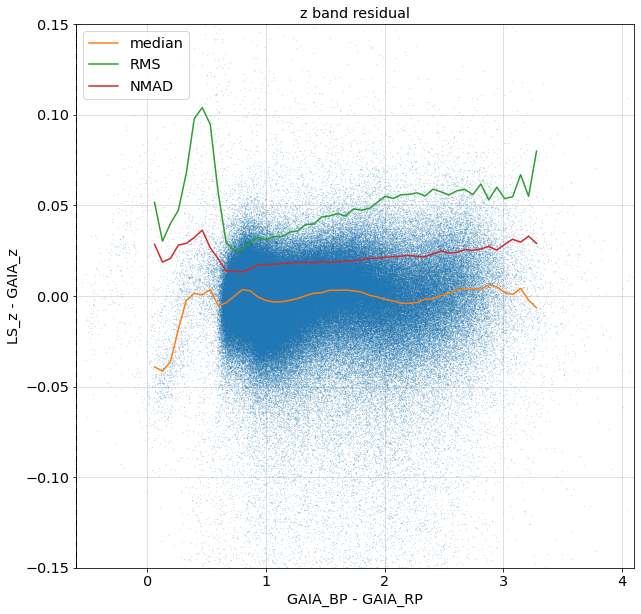

In [15]:
for band in ['g', 'r', 'z']:
    x = cat['PHOT_BP_MEAN_MAG']-cat['PHOT_RP_MEAN_MAG']
    y_tractor = cat[band+'mag']
    y_predict = cat[band+'mag_predict']

    print('RMS', np.std(y_tractor-y_predict))    
    print('NMAD', nmad(y_tractor-y_predict))
    
    bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)
    bin_center, bin_edges, bin_std = binned_std(x, y_tractor-y_predict)
    bin_center, bin_edges, bin_nmad = binned_nmad(x, y_tractor-y_predict)
    
    plt.figure(figsize=(10, 10))
    plt.plot(x, y_tractor-y_predict, '.', ms=0.3, alpha=0.5, zorder=2)
    plt.plot(bin_center, bin_median, label='median')
    plt.plot(bin_center, bin_std, label='RMS')
    plt.plot(bin_center, bin_nmad, label='NMAD')
    plt.axvline(bprp_min, lw=1, ls='-.', color='k')
    plt.axvline(bprp_max, lw=1, ls='-.', color='k')
    plt.xlabel('GAIA_BP - GAIA_RP')
    plt.ylabel('LS_{0} - GAIA_{0}'.format(band))
    plt.title('{} band residual'.format(band))
    plt.axis([bprp_min, bprp_max, -0.15, 0.15])
    plt.grid(alpha=0.5)
    plt.legend(markerscale=10, loc='upper left')
    plt.savefig('plots/decals_{}_residual.png'.format(band))
    plt.show()